In [1]:
from DataParser import DataParser
import numpy as np
import scipy.sparse as sps
from sklearn.model_selection import KFold

from Data_manager.split_functions.split_train_validation_random_holdout import \
split_train_in_two_percentage_global_sample

from matplotlib.pyplot import figure
from SimpleEvaluator import evaluator
from Base.Evaluation.Evaluator import EvaluatorHoldout

In [2]:
from FeatureWeighting.CFW_D_Similarity_Linalg import CFW_D_Similarity_Linalg
from KNN.ItemKNNCBFRecommender import ItemKNNCBFRecommender
from GraphBased.RP3betaRecommender import RP3betaRecommender

seed = 1666
parser = DataParser()

URM_all = parser.get_URM_all()
ICM_all = parser.get_ICM_all()

URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.85, seed = seed)

rec_for_boost = RP3betaRecommender(URM_all)
rec_for_boost.fit(**{'topK': 979, 'alpha': 0.44979381336457436, 'beta': 0.1676276580250147, 'normalize_similarity': False})
W_sparse = rec_for_boost.W_sparse

CFW_weithing = CFW_D_Similarity_Linalg(URM_train, ICM_all, W_sparse)
CFW_weithing.fit(**{'topK': 69, 'add_zeros_quota': 0.99758453742112, 'normalize_similarity': False})

RP3betaRecommender: URM Detected 1079 (4.15 %) cold items.
CFW_D_Similarity_Linalg: URM Detected 32 (0.40 %) cold users.
CFW_D_Similarity_Linalg: URM Detected 1937 (7.46 %) cold items.
CFW_D_Similarity_Linalg: Generating train data
Similarity column 25975 ( 100 % ), 2413.49 column/sec, elapsed time 0.18 min
CFW_D_Similarity_Linalg: Collaborative S density: 1.11E-02, nonzero cells 7508891
CFW_D_Similarity_Linalg: Content S density: 2.64E-03, nonzero cells 1784554
CFW_D_Similarity_Linalg: Generating train data. Sample 1523037 ( 170.48 %) 
CFW_D_Similarity_Linalg: Content S structure has 152701 out of 1784554 ( 8.56%) nonzero collaborative cells
CFW_D_Similarity_Linalg: Nonzero collaborative cell sum is: 1.20E+04, average is: 7.89E-02, average over all collaborative data is 4.41E-02
Similarity column 25975 ( 100 % ), 2490.26 column/sec, elapsed time 0.17 min


In [10]:
import sys
np.set_printoptions(threshold=sys.maxsize)
argsort_features = np.argsort(-CFW_weithing.D_best)
n_to_select = int(0.3*len(argsort_features))
selected_features = argsort_features[:n_to_select]
print(repr(selected_features))

array([ 6278,  1578, 10650, 18436,  6260,  3119,   958,   187, 19000,
       14260,  3238,   147,   774,  7075, 17497, 14728, 10924,  7375,
       14095,   743,  2859, 13231, 10592,  8225, 19429,  7533, 16256,
        1188, 10901, 15657, 15411, 14828, 13743, 13610, 11374, 10036,
       15696, 13170,  8239, 18592,  6955, 11936, 17962,  5595,  8307,
       17121, 15119,  9398,  2790,  8355,  6763,  3100,   156, 15267,
        2572,  6465, 13504,  4999, 16512, 11547, 12295, 13355,  4852,
        1017, 11431,  3089, 12942,  5469, 14088,  3080, 17135,  2903,
         165,  2961, 12761,  4702,  5291, 13908,  6525,  6561, 12692,
        8720,  6048,  9210,  5126,  9777,  3751, 13079, 10431,  7504,
        5167, 19925,  5516,  3420, 18725, 13643, 17343, 19029, 13251,
       12829,  1989,   507, 13371,  4149,  1798, 17456, 17360,  4855,
       13312, 19724, 19930, 19932,  9822,  1545,  7584,  6971, 12728,
        9361, 11688,  9167, 14191, 19583,  8909,  1339, 16950,  5597,
       10944,  5296,

In [4]:
icb = ItemKNNCBFRecommender(URM_train, ICM_all)
icb.fit(**{'topK': 164, 'shrink': 8, 'similarity': 'jaccard', 'normalize': True})

ItemKNNCBFRecommender: URM Detected 32 (0.40 %) cold users.
ItemKNNCBFRecommender: URM Detected 1937 (7.46 %) cold items.
Similarity column 25975 ( 100 % ), 5060.62 column/sec, elapsed time 0.09 min


In [10]:
from KNN.SpecialItemKNNCBFRecommender import SpecialItemKNNCBFRecommender
icbsup = SpecialItemKNNCBFRecommender(URM_train, ICM_all)
icbsup.fit(**{'topK': 1000, 'shrink': 1000, 'similarity': 'cosine', 'normalize': True, 'feature_weighting': 'BM25'})

Special-ItemKNNCBFRec: URM Detected 32 (0.40 %) cold users.
Special-ItemKNNCBFRec: URM Detected 1937 (7.46 %) cold items.
Similarity column 25975 ( 100 % ), 4217.25 column/sec, elapsed time 0.10 min


In [5]:
evaluator_test = EvaluatorHoldout(URM_validation, cutoff_list=[10])
results_dict, _ = evaluator_test.evaluateRecommender(icb)
results_dict

EvaluatorHoldout: Processed 5002 ( 100.00% ) in 3.08 sec. Users per second: 1622


{10: {'ROC_AUC': 0.09587827567385745,
  'PRECISION': 0.019772091163534417,
  'PRECISION_RECALL_MIN_DEN': 0.08453047352487578,
  'RECALL': 0.08287614149090825,
  'MAP': 0.035209315933490505,
  'MRR': 0.06555108115483955,
  'NDCG': 0.0537570861990421,
  'F1': 0.031927186322955055,
  'HIT_RATE': 0.19772091163534586,
  'ARHR': 0.07274510830588393,
  'NOVELTY': 0.005374248394604899,
  'AVERAGE_POPULARITY': 0.019225405076064815,
  'DIVERSITY_MEAN_INTER_LIST': 0.9976224427245698,
  'DIVERSITY_HERFINDAHL': 0.999742299801391,
  'COVERAGE_ITEM': 0.5479114533205005,
  'COVERAGE_ITEM_CORRECT': 0.03476419634263715,
  'COVERAGE_USER': 0.6294199068831006,
  'COVERAGE_USER_CORRECT': 0.10079275198187995,
  'DIVERSITY_GINI': 0.26586695626646173,
  'SHANNON_ENTROPY': 12.994533326239228}}

In [6]:
results_dict, _ = evaluator_test.evaluateRecommender(CFW_weithing)
results_dict

EvaluatorHoldout: Processed 5002 ( 100.00% ) in 2.89 sec. Users per second: 1729


{10: {'ROC_AUC': 0.09748071406358097,
  'PRECISION': 0.01963214714114339,
  'PRECISION_RECALL_MIN_DEN': 0.07902934064469443,
  'RECALL': 0.07722457958011235,
  'MAP': 0.035451890546376555,
  'MRR': 0.07044118860392337,
  'NDCG': 0.053159022105724416,
  'F1': 0.03130571020829243,
  'HIT_RATE': 0.19632147141143544,
  'ARHR': 0.0792352900109796,
  'NOVELTY': 0.005415643815071398,
  'AVERAGE_POPULARITY': 0.016952802212448305,
  'DIVERSITY_MEAN_INTER_LIST': 0.9960714694326229,
  'DIVERSITY_HERFINDAHL': 0.9995872334792593,
  'COVERAGE_ITEM': 0.4119730510105871,
  'COVERAGE_ITEM_CORRECT': 0.03372473532242541,
  'COVERAGE_USER': 0.6294199068831006,
  'COVERAGE_USER_CORRECT': 0.09714357619227382,
  'DIVERSITY_GINI': 0.1756800713653559,
  'SHANNON_ENTROPY': 12.387618023514829}}

In [11]:
results_dict, _ = evaluator_test.evaluateRecommender(icbsup)
results_dict

EvaluatorHoldout: Processed 5002 ( 100.00% ) in 3.85 sec. Users per second: 1298


{10: {'ROC_AUC': 0.10140982495890544,
  'PRECISION': 0.020251899240303694,
  'PRECISION_RECALL_MIN_DEN': 0.08601606976257122,
  'RECALL': 0.08449305298328177,
  'MAP': 0.03688283262532723,
  'MRR': 0.0693874037686512,
  'NDCG': 0.05587507317159943,
  'F1': 0.03267259680200159,
  'HIT_RATE': 0.20251899240303878,
  'ARHR': 0.07642403356117874,
  'NOVELTY': 0.005368268242286356,
  'AVERAGE_POPULARITY': 0.018502717960434855,
  'DIVERSITY_MEAN_INTER_LIST': 0.9975132602427935,
  'DIVERSITY_HERFINDAHL': 0.9997313837359898,
  'COVERAGE_ITEM': 0.5568431183830607,
  'COVERAGE_ITEM_CORRECT': 0.03557266602502406,
  'COVERAGE_USER': 0.6294199068831006,
  'COVERAGE_USER_CORRECT': 0.1049452623631559,
  'DIVERSITY_GINI': 0.2672107335076441,
  'SHANNON_ENTROPY': 12.984279640411438}}

No handles with labels found to put in legend.


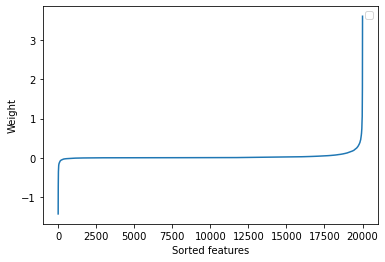

In [7]:
import matplotlib.pyplot as pyplot
%matplotlib inline  

pyplot.plot(np.sort(CFW_weithing.D_best))
pyplot.ylabel('Weight')
pyplot.xlabel('Sorted features')
pyplot.legend()
pyplot.show()

In [14]:
argsort_features = np.argsort(-CFW_weithing.D_best)

map_list = []
selection_quota_list = [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]

for selection_quota in selection_quota_list:
    
    n_to_select = int(selection_quota*len(argsort_features))
    selected_features = argsort_features[:n_to_select]
    
    ICM_selected = ICM_all[:,selected_features]
    
    print("Selected {}/{} features, weights: {:.2E} to {:.2E}".format(n_to_select, len(argsort_features),
                                                                min(CFW_weithing.D_best[selected_features]),
                                                                max(CFW_weithing.D_best[selected_features])))
    
    itemKNNCBF = ItemKNNCBFRecommender(URM_train, ICM_selected)
    itemKNNCBF.fit(**{'topK': 164, 'shrink': 8, 'similarity': 'jaccard', 'normalize': True})
    
    results_dict, _ = evaluator_test.evaluateRecommender(itemKNNCBF)
    map_list.append(results_dict[10]["MAP"])

Selected 4000/20000 features, weights: 2.40E-02 to 3.61E+00
ItemKNNCBFRecommender: URM Detected 32 (0.40 %) cold users.
ItemKNNCBFRecommender: URM Detected 1937 (7.46 %) cold items.
Similarity column 25975 ( 100 % ), 6793.79 column/sec, elapsed time 0.06 min
EvaluatorHoldout: Processed 5002 ( 100.00% ) in 2.85 sec. Users per second: 1755
Selected 5000/20000 features, weights: 1.59E-02 to 3.61E+00
ItemKNNCBFRecommender: URM Detected 32 (0.40 %) cold users.
ItemKNNCBFRecommender: URM Detected 1937 (7.46 %) cold items.
Similarity column 25975 ( 100 % ), 6221.40 column/sec, elapsed time 0.07 min
EvaluatorHoldout: Processed 5002 ( 100.00% ) in 2.82 sec. Users per second: 1776
Selected 6000/20000 features, weights: 1.04E-02 to 3.61E+00
ItemKNNCBFRecommender: URM Detected 32 (0.40 %) cold users.
ItemKNNCBFRecommender: URM Detected 1937 (7.46 %) cold items.
Similarity column 25975 ( 100 % ), 5555.81 column/sec, elapsed time 0.08 min
EvaluatorHoldout: Processed 5002 ( 100.00% ) in 2.87 sec. Use

No handles with labels found to put in legend.


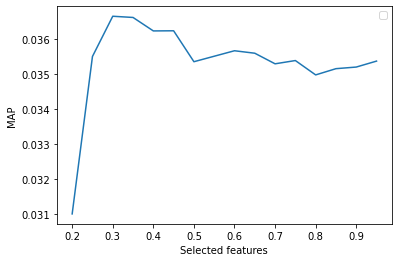

In [15]:
pyplot.plot(selection_quota_list, map_list)
pyplot.ylabel('MAP')
pyplot.xlabel('Selected features')
pyplot.legend()
pyplot.show()

In [16]:
map_list

[0.03101173995632283,
 0.03549560208670371,
 0.03664157825154136,
 0.03660681837746122,
 0.03622357982355051,
 0.03622747411491429,
 0.03534659076656558,
 0.03565878731651703,
 0.03558848087749023,
 0.0352868159866313,
 0.035379867768186225,
 0.03497086807126479,
 0.03514832061632384,
 0.035194370758877075,
 0.035363994582313145]